# Final Project - Real-Time Lane Detection Using OpenCV

> Prepared by: Eliseo Ruiz Nowell

## Project Abstract

For high-level goals, this project uses computer vision techniques learned in CS 484/684 and OpenCV to determine
- the bounds defined by the left and right lane lines
- the curvature of the lane
- the position of the car relative to the center of the lane

given a video stream of a car driving down a road.

Human drivers are prone to many mistakes that computers are not. Human drivers get distracted, get tired, or fail to do something well despite previous mastery. The **methodology** of using computer vision is that computers do not have the same shortcomings as humans, but they themselves do have different weaknesses. Computer vision in this project takes advantage of limited **bright** street painted lines to estimate where the lane currently is. With enough accuracy and speed, this information can subsequently be used to control the car **autonomously**. With enough improvements, autonomous vehicles are predicted to revolutionize the near future.

The project is divided into 9 parts. Each part progressively introduces new functions that will evenetually be used in a 2-stage pipeline to transform an input image into an image with the computer determined lanes overlayed ontop. To do so, several techniques learned in CS 484 are applied. Tangibly, the modules used are listed here with their use.
* Image Processing for Edge Detection and Kernel Smoothing to detect lanes (Module 3)
* Perspective Transform (Modules 4 & 5)
* Estimating Polynomial Fit for lane lines (Module 6)
* A new way to segment the lane pixels from the mask (Module 9)
* Overfitting the HLS parameters to 1 video vs Generalizing (Module 10)

The breadth of modules incorporated make it a good final project for this course. Finally, this project includes sample outputs and inputs for which the reviewer can test with. These should show how the algorithm performs under a variety of situations.

Large credit is due to [this website tutorial](https://automaticaddison.com/the-ultimate-guide-to-real-time-lane-detection-using-opencv/) for inspiration in this project.

Project discussed with and **approved by** professor Yuri Boykov.

**NOTE:** You can't see images in the PDF :( Please check out the notebook to see them! My browsers have stopped rendering pictures during PDF generation...

## Code Libraries
The essential libraries used in this project are the following:
* `IPython` - Used to display an embedded video in a notebook
* `matplotlib` - Plotting library to visualize results
* `numpy` - Scientific computation library for efficient operations on arrays
* `opencv-python` - Library used for common computer vision operations
* `os` - Used to find sample images in project directory
* `scipy` - Used to perform a quick sliding window average on a histogram
* `time` - Use to time how long lane overlay takes

## Part 1 - Setting Up

We want to be able to detect lane boundaries. We'll test our final algorithm on different levels of difficulty to see how it performs. The videos used are like the one found here on [Pixabay.com](Pixabay.com).

Links
* [Sunny Video](https://pixabay.com/videos/highway-germany-drive-traffic-10364/)
* [Lane Change Video](https://pixabay.com/videos/traffic-highway-freeway-road-8355/)
* [Raining Video](https://pixabay.com/videos/driving-rain-freeway-highway-8359/)

Make sure you have IPython installed:

In [1]:
# pip install IPython

Make sure you have OpenCV installed:

In [2]:
# pip install opencv-python

In [3]:
import cv2
from IPython import display
import matplotlib.pyplot as plt
import numpy as np
import os
from scipy.ndimage.filters import uniform_filter1d
import time

Some values do not change between images because we can count on the dashcam being the same for each image. The pattern we will follow in this project is that we first define constants we use and then use them in functions in subsequent fuctions.

For example, to start, let's hardcode the dimensions of the images we know we will get from our dashcam. Also we can hardcode our initial test image name.

In [4]:
DASHCAM_HEIGHT = 1080
DASHCAM_WIDTH = 1920

# TRY CHANGING ME ! ! !

TEST_IMAGE_NAME = "images/samples/sunny_base_case.png"
# TEST_IMAGE_NAME = "images/samples/nighttime_no_oncoming.png"
# TEST_IMAGE_NAME = "images/samples/raining_less_cars.png"
# TEST_IMAGE_NAME = "images/samples/lane_change_incoming.png"

For code, we can begin by loading in the sample image we have included with this project.

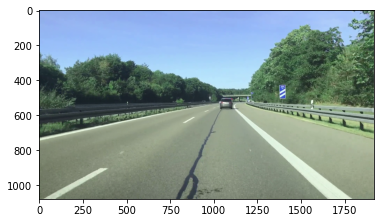

In [5]:
original_frame = cv2.imread(TEST_IMAGE_NAME)

plt.imshow(cv2.cvtColor(original_frame, cv2.COLOR_BGR2RGB))

## Part 2 - Thresholding

Next, we want to convert the image to a representation that lets us identify the lane split indicators.

Images are normally represented by RGB components. However to distinguish the bright white/yellow from dark black/gray we can convert the image to a Hue, Luminosity, and Saturation (HLS) representation.
- Hue: The dominant color present in the pixel
- Saturation: How little "gray" light that pixel has
- Luminosity (Brightness): How much "white" light that pixel has (how bright it is)

Because line roads are usually a bright white or yellow and the road is black or grey, we can use the luminosity, the saturation, and the red channel components to locate them.

Converting to HLS format is easy with OpenCV, but we do have to be aware that by default OpenCV images are loaded in as BGR images not RBG images.

In [6]:
hls = cv2.cvtColor(original_frame, cv2.COLOR_BGR2HLS)

Next we define some crucial constants: The Luminosity, the Red, and the Saturation thresholds. These parameters are very important towards detecting the lanes in the videos.

These variables are a source of "overfitting" for the model. The right parameters will make the current video look _really_ good, but will make other videos look very bad. The main discrepancy here is most likely due to difference in camera picture quality and car lighting, but the different weather conditions are unavoidable in real life and a prime example of a situation where a computer has weaknesses that a human does not.

For convenience, we select the parameters based on the `TEST_IMAGE_NAME` you selected. But feel free to edit this cell to see how parameters good for one video are not good for another.

You will notice that luminosity and red channel had the same numbers in each picture. This makes sense because lumiscent (bright) colors in these cases use white to make them bright which in turn has a high red component.

In [7]:
# Manually Tuned values
if TEST_IMAGE_NAME.startswith("images/samples/sunny"):
    # Sunny
    LUMINOSITY_THRESHOLD = 180
    RED_THRESHOLD = 180
    SATURATION_THRESHOLD = 100
elif TEST_IMAGE_NAME.startswith("images/samples/nighttime"):
    # Night Time
    LUMINOSITY_THRESHOLD = 147
    RED_THRESHOLD = 147
    SATURATION_THRESHOLD = 37
elif TEST_IMAGE_NAME.startswith(
    "images/samples/raining"
) or TEST_IMAGE_NAME.startswith("images/samples/lane_change"):
    # Raining
    LUMINOSITY_THRESHOLD = 100
    RED_THRESHOLD = 100
    SATURATION_THRESHOLD = 7
else:
    raise (Exception("Add your own threshold values for this custom image!"))

Luminosity (brightness) can be visualized with this picture:

![TODO](images/luminosity.png)

The first step we can apply is to find a mask for the luminosity of the pixels in the image. In `find_luminosity`, we:
1. Use thresholding to find pixels with a large luminosity component

Next, in `find_edges`, we can find where the luminosity magnitude jumps to find the edges of the bright lanes on the dark pavement:
1. Use a Gaussian Filter to get more pronounced edges (necessary otherwise edge detector may not see the edge!)
1. Use a Sobel Edge detector which is simply a kernel that finds where pixels make jumps in luminosity

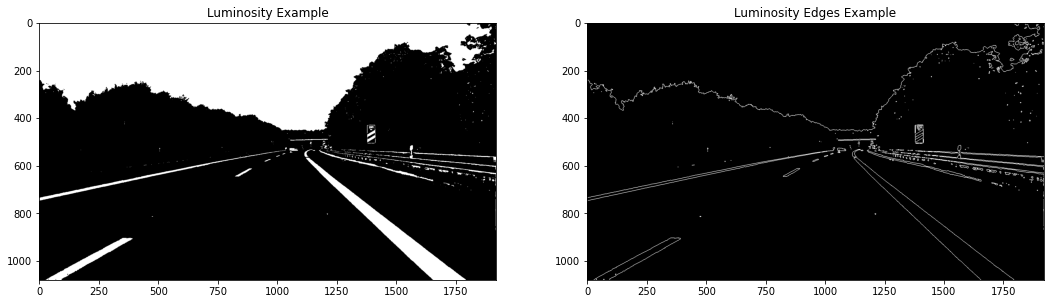

In [8]:
# Edge Detection on L values
def find_luminosity(
    hls_image, luminosity_min=LUMINOSITY_THRESHOLD
):
    # 1
    l_channel = hls_image[:, :, 1]
    _, binary_luminescent = cv2.threshold(
        l_channel, luminosity_min, 255, cv2.THRESH_BINARY
    )
    
    binary_luminescent[binary_luminescent == 255] = 1
    
    return binary_luminescent


def find_edges(img_mask, edge_jump_min_mag=2, k_size=3):
    # 2
    blurred_img = cv2.GaussianBlur(
        img_mask, (k_size, k_size), 0
    )
    # 3
    sobelx = np.absolute(
        cv2.Sobel(blurred_img, cv2.CV_64F, 1, 0, k_size)
    )
    sobely = np.absolute(
        cv2.Sobel(blurred_img, cv2.CV_64F, 0, 1, k_size)
    )
    edges_mags = np.sqrt(sobelx ** 2 + sobely ** 2)
    binary_edges = np.zeros_like(edges_mags)
    binary_edges[(edges_mags >= edge_jump_min_mag)] = 1
    return binary_edges


# Plot

luminosity_mask = find_luminosity(hls)
edges_map = find_edges(luminosity_mask)

fig = plt.figure(figsize=(18, 18))

ax1 = fig.add_subplot(1, 2, 1)
ax1.set_title("Luminosity Example")
ax1.imshow(luminosity_mask, cmap="gray")
ax2 = fig.add_subplot(1, 2, 2)
ax2.set_title("Luminosity Edges Example")
ax2.imshow(edges_map, cmap="gray")

Next, to fill in the lines, we check the saturation of the HLS image and the red values of the BGR image. In `find_saturated` we do the following:

1. Find highly saturated values of the HLS image to find strong shades with little gray light as we expect from yellow or white lines.

In `find_red` we:
1. Threshold pixels on their red components because yellow and white lines have very strong red components.

Saturation can be visualized as follows:

![TODO](images/saturation.png)

Initially my edges weren't combining with these saturation values properly. That was because my edge map was on a range from (0, 1) while the saturation/red_channel map was on a range from (0, 255). That makes sense because red is a color defined in the RGB 0-255 space. Converting the saturation/red_channel to a binary (0, 1) map fixed the problem.

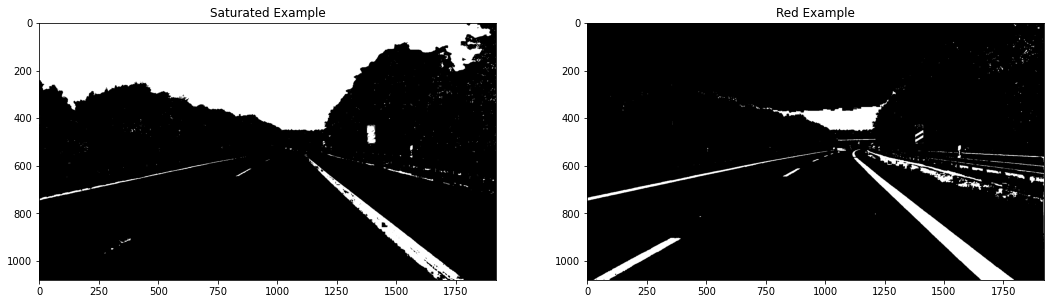

In [9]:
def find_saturated(hls_img, saturation_thresh=SATURATION_THRESHOLD):
    # 1
    s_channel = hls_img[:, :, 2]
    _, binary_saturation = cv2.threshold(
        s_channel, saturation_thresh, 255, cv2.THRESH_BINARY
    )
    
    binary_saturation[binary_saturation == 255] = 1 # TRICKY

    return binary_saturation

def find_red(original_img, red_thresh=RED_THRESHOLD):
    # 1
    r_channel = original_img[:, :, 2]
    _, binary_red = cv2.threshold(r_channel, red_thresh, 255, cv2.THRESH_BINARY)
    
    binary_red[binary_red == 255] = 1 # TRICKY

    return binary_red

# Plot

saturated_example = find_saturated(hls)

red_example = find_red(original_frame)

fig = plt.figure(figsize=(18, 18))

ax1 = fig.add_subplot(1, 2, 1)
ax1.set_title("Saturated Example")
ax1.imshow(saturated_example, cmap="gray")
ax2 = fig.add_subplot(1, 2, 2)
ax2.set_title("Red Example")
ax2.imshow(red_example, cmap="gray")

Finally, we can put the components together.

We do the following:
1. We AND the saturation and red values together for added accuracy
2. We OR the luminosity edges and saturation/red combination

This combination of image components is what empirically worked best. Saturation and Red helped keep each other in check (especially when Saturation couldn't find anything useful due to dim lanes). Red was mostly covered by Luminosity anyways and usually had really good results. Their combination and Luminosity Edges were considered equally important. The resulting OR-ed image has edges defined and lanes filled out as best as it can without too much noise.

Luminosity and Red received pretty similar results most of the time. For that reason, I would say the most important parameters is luminosity/red. The edges were helpful but could be more helpful if we enforce a width between edges that we expect for lanes and if we made use of the direction of the Sobel detection kernel to ensure luminosity increases from left to right and decreases from right to left as it does for lanes on dark pavement.

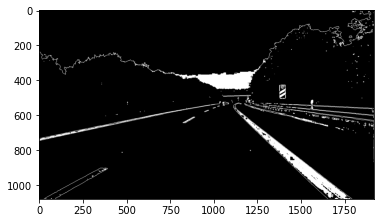

In [10]:
def find_lane_lines_and_edges(original_img):
    hls_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2HLS)
    
    luminosity_mask = find_luminosity(hls_img)
    edges_map = find_edges(luminosity_mask)

    saturated_mask = find_saturated(hls_img)
    
    red_mask = find_red(original_img)
    
    # 1
    saturated_and_red = cv2.bitwise_and(saturated_mask, red_mask)
    
    # 2
    merged_binary = cv2.bitwise_or(
        saturated_and_red, edges_map.astype(np.uint8)
    )

    return merged_binary


lane_lines_and_edges = find_lane_lines_and_edges(original_frame)

# Plot

plt.imshow(lane_lines_and_edges, cmap="gray")


Now we can use this binary mask to find where the lane lines are!

We really would like this to generalize well, so we see how the parameters we selected perform under many different samples as provided in the project.

Loading sunny_base_case.png...
Loading lane_change_incoming.png...
Loading nighttime_no_oncoming.png...
Loading raining_windshield_wipers.png...
Loading raining_blocking_trailer.png...
Loading nighttime_oncoming_car.png...
Loading raining_less_cars.png...


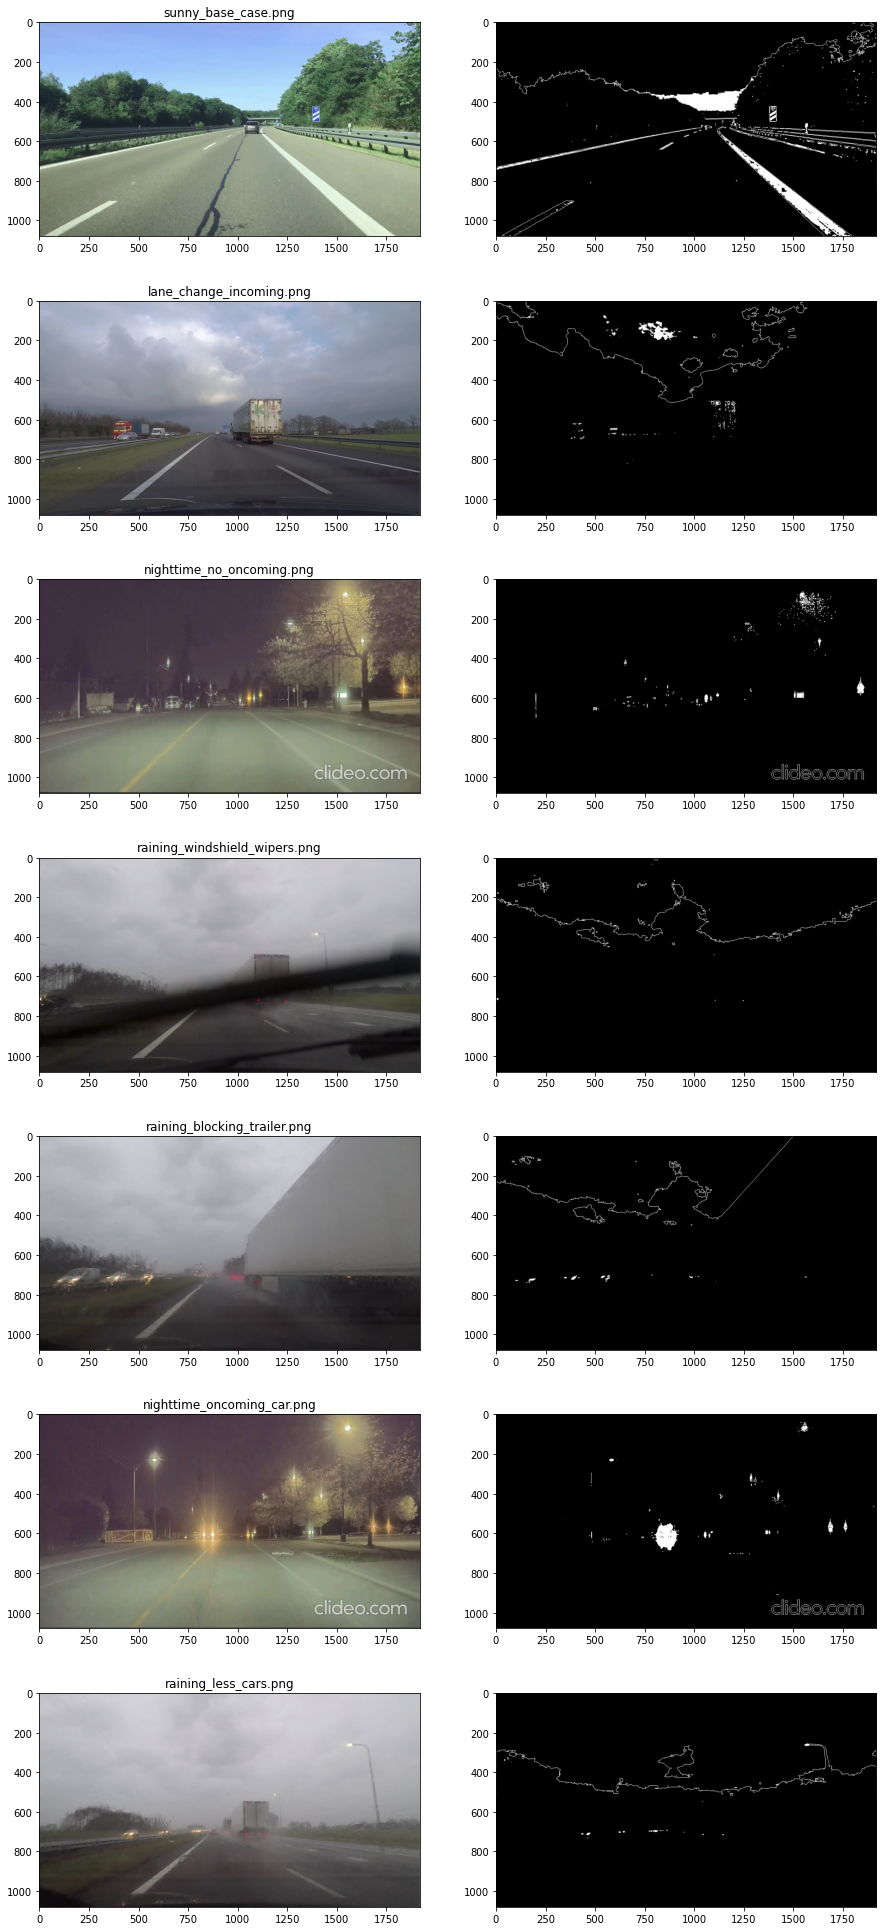

In [11]:
# Plot

sample_images = os.listdir("images/samples")
num_sample_img = len(sample_images)

fig = plt.figure(figsize=(15, 5 * num_sample_img))
count = 1
for sample_filename in sample_images:
    print(f"Loading {sample_filename}...")
    
    ax = fig.add_subplot(num_sample_img, 2, count)
    ax.set_title(sample_filename)
    
    sample_img_frame = cv2.imread(f"images/samples/{sample_filename}")
    ax.imshow(cv2.cvtColor(sample_img_frame, cv2.COLOR_BGR2RGB))
    count += 1
    
    ax = fig.add_subplot(num_sample_img, 2, count)
    sample_lines_and_edges = find_lane_lines_and_edges(sample_img_frame)
    ax.imshow(cv2.cvtColor(sample_lines_and_edges * 255, cv2.COLOR_BGR2RGB))
    count += 1

As we expected, the overfit parameters we picked for the current image perform well for images taken with **the same camera** but poorly for other ones.

Finding the right parameters to get the images above took quite a few tests and even still there might be better parameters.

The major difficulty was that these videos are from **different** cameras and **different** cars. 1 out of the 3 from [Pixabay.com](Pixabay.com) is form a different user (the `sunny.mp4` video) and `nighttime.mp4` is from my own car that I took at night time. The camera images have different exposures from the **car headlights** and produce different results based on the camera used.

Overall it was really interesting to see how the lines could pick up noise so easily. Headlights and street lights did a lot more harm than I thought they would, while the windshield wiper did a lot less than I thought it would.

## Part 3 - Apply a Projective Transform

Our image mask from before contains some noise. The far lane on the left is picked up but is not important for the car, the railing is not a lane, and the sky and the road sign are obviously not lanes either.

To focus on what we want, we can apply a **perspective transform** on the image to get a sort-of aerial view of the road's lines. Transforms like these are called "Image Warps" as we learned in Module 4.

Since we manually select our polygon size, we have to make sure it is small enough to not include noise in the transform, but also large enough to always identify the left AND right lanes. This transformation is the same between pictures so we define them as constants.

The desired points is the box to which the region of interest will project to. The constants defined here were emperically found to be the best at keeping information about the lane markings so that the lanes can be deduced from them.

In [12]:
RED_COLOR = (0, 0, 255)

# Manually Tuned values
if TEST_IMAGE_NAME.startswith("images/samples/sunny"):
    TEST_VIDEO_IMAGE_SAMPLE = "images/samples/sunny_base_case.png"
    REGION_OF_INTEREST_POINTS = np.float32(
        [
            (895, 587),  # Top-left corner
            (0, DASHCAM_HEIGHT - 1),  # Bottom-left corner
            (1_839, DASHCAM_HEIGHT - 1),  # Bottom-right corner
            (1_187, 587),  # Top-right corner
        ]
    )
elif TEST_IMAGE_NAME.startswith("images/samples/nighttime"):
    REGION_OF_INTEREST_POINTS = np.float32(
        [
            (775, 720),  # Top-left corner
            (382, DASHCAM_HEIGHT - 1),  # Bottom-left corner
            (1_600, DASHCAM_HEIGHT - 1),
            (1_136, 720),  # Bottom-right corner
        ]
    )
elif TEST_IMAGE_NAME.startswith(
    "images/samples/raining"
) or TEST_IMAGE_NAME.startswith("images/samples/lane_change"):
    REGION_OF_INTEREST_POINTS = np.float32(
        [
            (680, 800),  # Top-left corner
            (285, DASHCAM_HEIGHT - 1),  # Bottom-left corner
            (1_690, DASHCAM_HEIGHT - 1),  # Bottom-right corner
            (1_175, 800),  # Top-right corner
        ]
    )
else:
    raise (Exception("Add your own Region points for this custom image!"))

# Manually Tuned values
AERIAL_VIEW_PADDING = 250 # TRICKY
DESIRED_POINTS = np.float32(
    [
        (AERIAL_VIEW_PADDING, 0),  # Top-left corner
        (AERIAL_VIEW_PADDING, DASHCAM_HEIGHT),  # Bottom-left corner
        (DASHCAM_WIDTH - AERIAL_VIEW_PADDING, DASHCAM_HEIGHT),  # Bottom-right corner
        (DASHCAM_WIDTH - AERIAL_VIEW_PADDING, 0),  # Top-right corner
    ]
)

# Calculate the transformation matrix
TO_AERIAL_VIEW_MATRIX = cv2.getPerspectiveTransform(
    REGION_OF_INTEREST_POINTS, DESIRED_POINTS
)

# Calculate the inverse transformation matrix
TO_DASHCAM_VIEW_MATRIX = cv2.getPerspectiveTransform(
    DESIRED_POINTS, REGION_OF_INTEREST_POINTS
)


Now we can use these constants to perform the perspective transform.

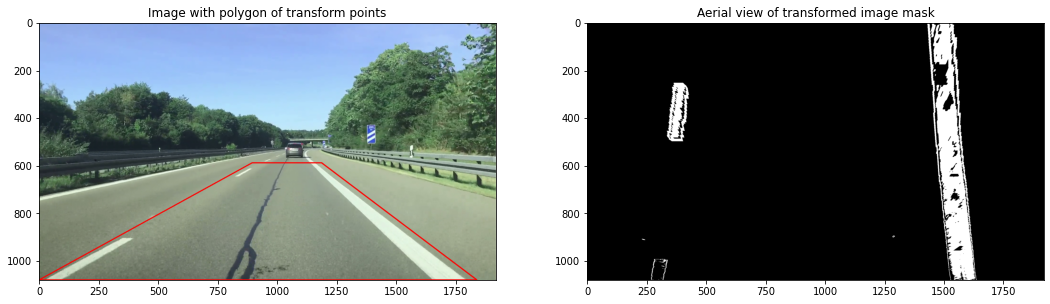

In [13]:
def get_lanes_perspective_view(
    lane_lines_mask, transformation_matrix, desired_points=DESIRED_POINTS
):
    # Perform the transform using the transformation matrix
    warped_frame = cv2.warpPerspective(
        lane_lines_mask,
        transformation_matrix,
        (DASHCAM_WIDTH, DASHCAM_HEIGHT),  # TRICKY
    )

    return warped_frame


warped_mask = get_lanes_perspective_view(
    lane_lines_and_edges, TO_AERIAL_VIEW_MATRIX
)

# Plot

fig = plt.figure(figsize=(18, 10))

ax1 = fig.add_subplot(1, 2, 1)
ax1.set_title("Image with polygon of transform points")
original_image_with_polygon = cv2.polylines(
    original_frame.copy(),
    np.int32([REGION_OF_INTEREST_POINTS]),
    True,
    RED_COLOR,
    3,
)
ax1.imshow(cv2.cvtColor(original_image_with_polygon, cv2.COLOR_BGR2RGB))
ax2 = fig.add_subplot(1, 2, 2)
ax2.set_title("Aerial view of transformed image mask")
ax2.imshow(warped_mask, cmap="gray")

This part turned out to be much more curcial than I thought. It's important to have a good region of interest. Initially my region of interest was slightly bigger on the left side, but as the street curved harder, it _was easier to pick up the opposite lane_ in the resultant mask!

To fix this I had to make the region smaller to be more strict about what got included once the transform was complete. But not so small that the left lane would completely dissapear, which could happen easily since the left lane is only painted in segments!

It is crtical to remark that the red polygon **does not decided what shows up in the mask** but only the points used in the transform. Specifically, I use `AERIAL_VIEW_PADDING` to allow for some lane lines outside the red polygon on **the sides to show up in the warp**. This is important because as the car moves slightly right or left, lane lines can dissapear so this padding helps increase the chances that lanes slightly out-of-view make it into the mask.

This padding ended up being MUCH more crucial than I thought. Its thoughtul selection guarded against suddenly jumps favoring lanes on the far end. This fixed some errors even present in the original tutorial's solution.

A future improvement could be to handle the case where only the right or only the left lane shows up more elegantly. Memory about the width of the road from a few seconds ago could be used to "guess" where the left lane is.

## Part 4 - Find the Lanes

Lanes are where the white pixels are. Lanes that are **closest** to the car are the most important, so we can use a **histogram** to assign how many pixels have the same x-coordinate in the _bottom 3/4ths of the image_ because the x-axis is what is right in front of the car and the bottom 3/4ths is closest to the car.

Previously, an issue I had was that I was only using the bottom half and that proved to produce poor results because it would miss lanes that were up far ahead. Especially when the lane was painted in segments!

In [14]:
WARPED_MASK_Y_OFFSET = int(DASHCAM_HEIGHT / 4) # TRICKY

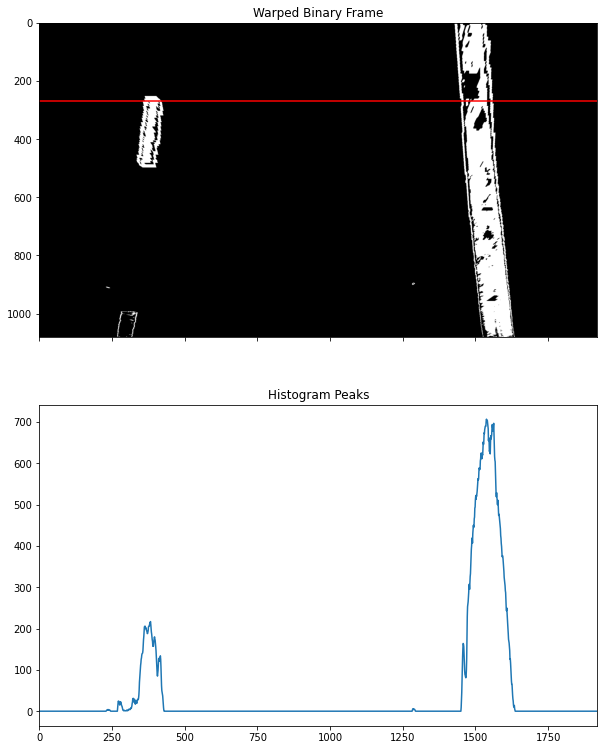

In [15]:
def unsmoothed_histogram(warped_img):
    return np.sum(warped_img[WARPED_MASK_Y_OFFSET:, :], axis=0)


lanes_histogram = unsmoothed_histogram(warped_mask)

# Plot

# Draw both the image and the histogram
fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True)
fig.set_size_inches(10, 13)  # TRICKY
ax1.set_title("Warped Binary Frame")
ax1.imshow(warped_mask, cmap="gray")
ax1.plot(
    np.linspace(0, DASHCAM_WIDTH - 1, 1000),
    [WARPED_MASK_Y_OFFSET] * 1000,
    c="r",
)
ax2.set_title("Histogram Peaks")
ax2.plot(lanes_histogram)

This histogram is not the best, because the progam can be fooled to think that there is a lane in the spikes of other locations which are caused by detection of high luminosity contrast road work or something else. In my trials this could hurt results considerably. This makes sense because the jump in luminosity is significant for things like gray roads to black roadwork. The jump does not have to be from gray to white.

Lanes are thick, so we can take a sliding window average to smooth the histogram out and pick out the lanes which may have smaller peaks but which have more points in a thick range.

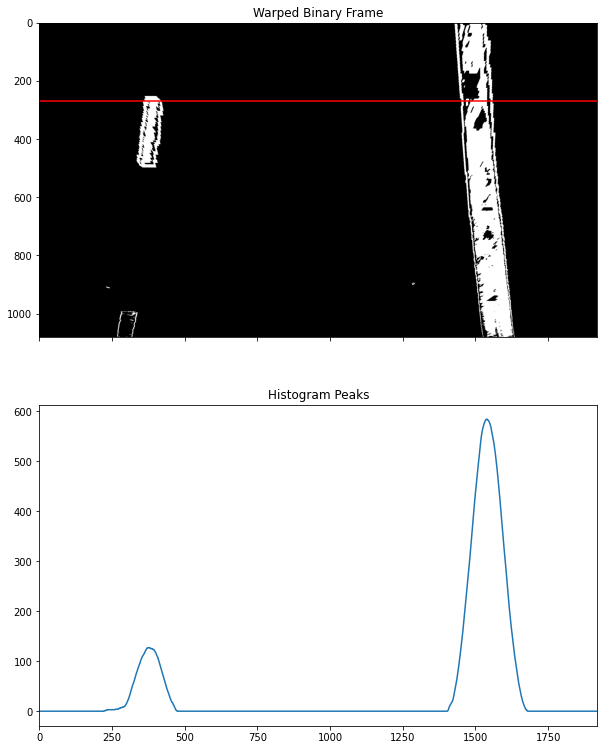

In [16]:
def get_histogram(warped_img):
    x = np.sum(warped_img[WARPED_MASK_Y_OFFSET:, :], axis=0)
    y = uniform_filter1d(x, size=100)
    return y


lanes_histogram = get_histogram(warped_mask)

# Plot

# Draw both the image and the histogram
fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True)
fig.set_size_inches(10, 13)  # TRICKY
ax1.set_title("Warped Binary Frame")
ax1.imshow(warped_mask, cmap="gray")
ax1.plot(
    np.linspace(0, DASHCAM_WIDTH - 1, 1000),
    [WARPED_MASK_Y_OFFSET] * 1000,
    c="r",
)
ax2.set_title("Histogram Peaks")
ax2.plot(lanes_histogram)

## Part 5 - Construct Lanes Overlay Using Sliding Windows

Next we will try to fit a polynomial curve onto the warped image that gives our prediction for where the lines of the lane extrapolate to, and the histogram is a great place to start.

To find this line, we will use two vertical stacks of sliding windows to track the curve of the lane. The windows start at the bottom of the image centered at the peaks of the histogram. Higher stacks of windows either stay at the same x value or slightly move left or right to _the mean X of the white pixels found inside the box_. All pixels found in sliding windows are remembered.

Finally, the idea is that non-lane pixels have been filtered out by the windows, so that only lane pixels remain. Using these we use the `np.polyfit` function to get a polynomial that fits these points as if it were a scatter plot. Line fitting is something we learning with RANSAC in Module 3.

First, we define some constants for the windows and for plotting in the cell below:

In [17]:
BLUE_COLOR = (255, 0, 0)
WHITE_COLOR = (255, 255, 255)

DASHCAM_WIDTH_MIDPOINT = int(DASHCAM_WIDTH / 2)
LANE_PARAMS_ZEROS = np.array([0, 0, 0])
MIN_PIXELS_TO_RECENTER = int((1 / 24) * DASHCAM_WIDTH)

NUM_WINDOWS = 10
WINDOW_HALF_WIDTH = int((1 / 24) * DASHCAM_WIDTH)
WINDOW_HEIGHT = np.int(DASHCAM_HEIGHT / NUM_WINDOWS)
WINDOW_Y_VALUES = [
    (y_idx * WINDOW_HEIGHT, (y_idx - 1) * WINDOW_HEIGHT)
    for y_idx in range(NUM_WINDOWS, 0, -1)
]

Y_RANGE = np.linspace(0, DASHCAM_HEIGHT - 1, DASHCAM_HEIGHT)

Next, we implement these windows to filter for lane pixels in `get_lane_line_indices_sliding_windows` below. We also use `get_lane_curve_params` to generate a polynomial curve from these pixels.

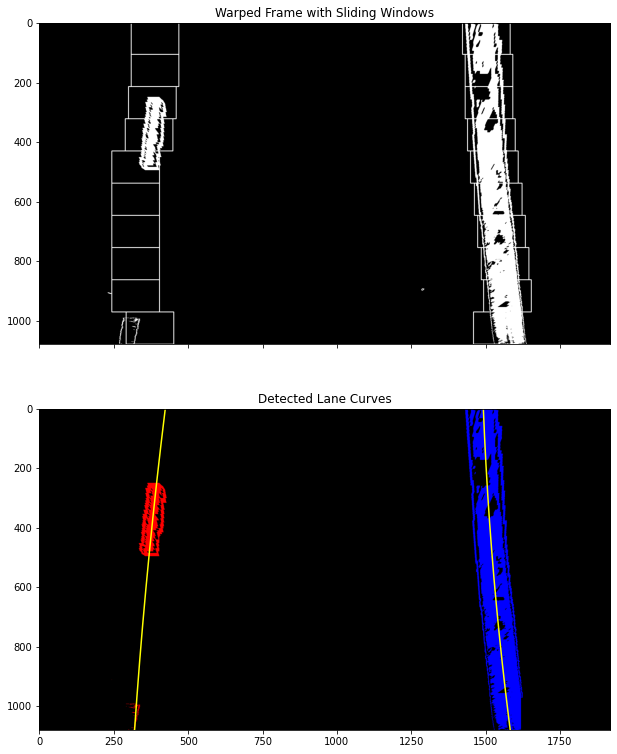

In [18]:
def get_lane_line_indices_sliding_windows(warped_img_binary_mask, histogram):
    windowed_warped_img = warped_img_binary_mask.copy() * 255  # TRICKY

    # Find the x and y coordinates of all the nonzero
    # (i.e. white) pixels in the frame.
    nonzero = warped_img_binary_mask.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    # Store the pixel indices for the left and right lane lines
    left_lane_pixels = []
    right_lane_pixels = []

    # Current positions for pixel indices for each window,
    # which we will continue to update
    left_peak_base_x = np.argmax(histogram[:DASHCAM_WIDTH_MIDPOINT])
    right_peak_base_x = DASHCAM_WIDTH_MIDPOINT + np.argmax(
        histogram[DASHCAM_WIDTH_MIDPOINT:]
    )

    current_lanes_center_xs = np.array([left_peak_base_x, right_peak_base_x])
    leftx_current = left_peak_base_x
    rightx_current = right_peak_base_x

    for win_y_low, win_y_high in WINDOW_Y_VALUES:
        win_xleft_low, win_xright_low = (
            current_lanes_center_xs - WINDOW_HALF_WIDTH
        )
        win_xleft_high, win_xright_high = (
            current_lanes_center_xs + WINDOW_HALF_WIDTH
        )
        cv2.rectangle(
            windowed_warped_img,
            (win_xleft_low, win_y_low),
            (win_xleft_high, win_y_high),
            WHITE_COLOR,
            2,
        )
        cv2.rectangle(
            windowed_warped_img,
            (win_xright_low, win_y_low),
            (win_xright_high, win_y_high),
            WHITE_COLOR,
            2,
        )

        # Identify the nonzero pixels in x and y within the window
        any_lane_pixel_with_y_in_current_window = (nonzeroy >= win_y_high) & (
            nonzeroy < win_y_low
        )  # TRICKY
        left_lane_pixels_in_current_window = (
            any_lane_pixel_with_y_in_current_window
            & (nonzerox >= win_xleft_low)
            & (nonzerox < win_xleft_high)
        ).nonzero()[0]
        right_lane_pixels_in_current_window = (
            any_lane_pixel_with_y_in_current_window
            & (nonzerox >= win_xright_low)
            & (nonzerox < win_xright_high)
        ).nonzero()[0]

        # Append these indices to the lists
        left_lane_pixels.append(left_lane_pixels_in_current_window)
        right_lane_pixels.append(right_lane_pixels_in_current_window)

        # If you found > minpix pixels, recenter next window on mean position
        if len(left_lane_pixels_in_current_window) > MIN_PIXELS_TO_RECENTER:
            current_lanes_center_xs[0] = np.int(
                np.mean(nonzerox[left_lane_pixels_in_current_window])
            )
        if len(right_lane_pixels_in_current_window) > MIN_PIXELS_TO_RECENTER:
            current_lanes_center_xs[1] = np.int(
                np.mean(nonzerox[right_lane_pixels_in_current_window])
            )

    # Concatenate the points found to be part of lanes
    left_lane_pixels = np.concatenate(left_lane_pixels)
    right_lane_pixels = np.concatenate(right_lane_pixels)

    # Extract the pixel coordinates for the left and right lane lines
    leftx = nonzerox[left_lane_pixels]
    lefty = nonzeroy[left_lane_pixels]
    rightx = nonzerox[right_lane_pixels]
    righty = nonzeroy[right_lane_pixels]

    return (leftx, lefty, rightx, righty), windowed_warped_img


def get_lane_curve_params(x, y):
    # If no lane points were found, return a 0 polynomial
    if len(x) == 0:
        return LANE_PARAMS_ZEROS
    # Fit a second order polynomial curve to the pixel coordinates for
    # the left and right lane lines
    return np.polyfit(y, x, 2)


((l_x, l_y, r_x, r_y), windowed_mask) = get_lane_line_indices_sliding_windows(
    warped_mask, lanes_histogram
)
l_curve_params = get_lane_curve_params(l_x, l_y)
r_curve_params = get_lane_curve_params(r_x, r_y)

left_fitx = (
    l_curve_params[0] * Y_RANGE ** 2
    + l_curve_params[1] * Y_RANGE
    + l_curve_params[2]
)
right_fitx = (
    r_curve_params[0] * Y_RANGE ** 2
    + r_curve_params[1] * Y_RANGE
    + r_curve_params[2]
)

# Plot

# Convert BW Image to RGB by going from 1 Channel -> 3 Channels
mask_with_lane_lines = np.stack([warped_mask] * 3, axis=-1)

mask_with_lane_lines[l_y, l_x] = np.array(BLUE_COLOR)
mask_with_lane_lines[r_y, r_x] = np.array(RED_COLOR)

fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True)
fig.set_size_inches(13, 13)
ax1.set_title("Warped Frame with Sliding Windows")
ax1.imshow(windowed_mask, cmap="gray")
ax2.set_title("Detected Lane Curves")
ax2.imshow(mask_with_lane_lines)
valid_left_domain = (left_fitx > 0) & (left_fitx < DASHCAM_WIDTH)
valid_right_domain = (right_fitx > 0) & (right_fitx < DASHCAM_WIDTH)

left_lane_x_points = left_fitx[valid_left_domain]
right_lane_x_points = right_fitx[valid_right_domain]
left_lane_y_points = Y_RANGE[valid_left_domain]
right_lane_y_points = Y_RANGE[valid_right_domain]
ax2.plot(left_lane_x_points, left_lane_y_points, color="yellow")
ax2.plot(right_lane_x_points, right_lane_y_points, color="yellow")


In Module 9, we talked about using histograms of colors to segment each pixel as being part of a group or not. That same technique could be applied here and then we would find the points to create the lane curve. This is just another example which executes quickly as is needed in real-time applications such as lane detection for car cameras.

Further, we also have no seeds here so we cannot using techniques such as region-growing or graph cut. For an example that uses these techniques refer back to Assignment 4.

Next, in Module 6, we talked about using "Least Mean Squares" to create a model that describes a series of points with the least amount of error. First, we found our points through "segmentation" and this sliding window method. Now, by using the [numpy.polyfit](https://numpy.org/doc/stable/reference/generated/numpy.polyfit.html) method we minimize the least squared error and find a polynomial that fits these points.

Using these curves, we can create full solid lanes on this warped images. First we define constants we need.

In [19]:
GREEN_COLOR = (0, 255, 0)

Now we draw the lanes on the warped image:

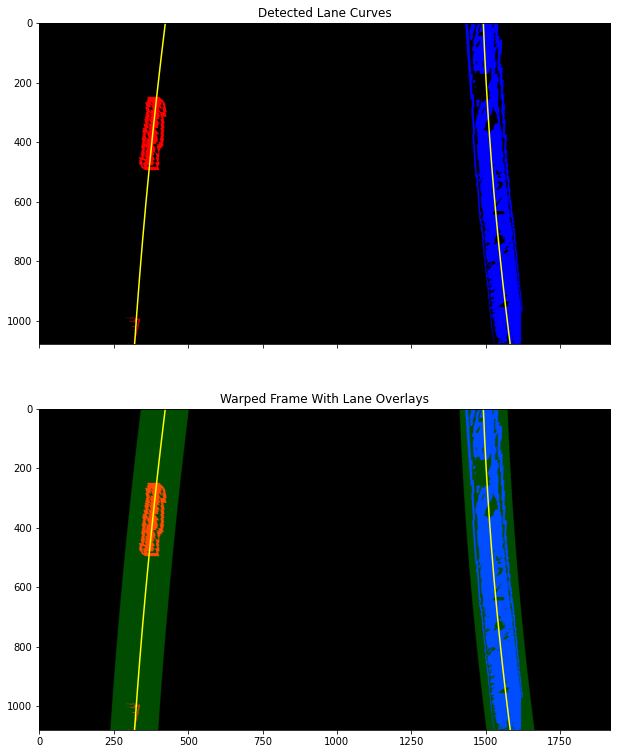

In [20]:
def get_lane_points(left_lane_x, right_lane_x, image_y):
    l_lane_l_xy_points = np.hstack([left_lane_x - WINDOW_HALF_WIDTH, image_y])
    l_lane_r_xy_points = np.flipud(
        np.hstack([left_lane_x + WINDOW_HALF_WIDTH, image_y])
    )

    r_lane_l_xy_points = np.hstack([right_lane_x - WINDOW_HALF_WIDTH, image_y])
    r_lane_r_xy_points = np.flipud(
        np.hstack([right_lane_x + WINDOW_HALF_WIDTH, image_y])
    )

    return (
        l_lane_l_xy_points,
        l_lane_r_xy_points,
        r_lane_l_xy_points,
        r_lane_r_xy_points,
    )


(ll_xy_points, lr_xy_points, rl_xy_points, rr_xy_points) = get_lane_points(
    left_fitx[..., np.newaxis],
    right_fitx[..., np.newaxis],
    Y_RANGE[..., np.newaxis],
)

# Plot

left_line_pts = np.vstack((ll_xy_points, lr_xy_points))
right_line_pts = np.vstack((rl_xy_points, rr_xy_points))

# Draw the left and right lanes onto the warped blank image
lane_overlays = np.zeros_like(mask_with_lane_lines)
cv2.fillPoly(lane_overlays, np.int_([left_line_pts]), GREEN_COLOR)
cv2.fillPoly(lane_overlays, np.int_([right_line_pts]), GREEN_COLOR)
mask_with_lane_overlays = cv2.addWeighted(
    mask_with_lane_lines, 1, lane_overlays, 0.3, 0
)

fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True)
fig.set_size_inches(13, 13)

ax1.set_title("Detected Lane Curves")
ax1.imshow(mask_with_lane_lines)
ax1.plot(
    left_fitx[valid_left_domain], Y_RANGE[valid_left_domain], color="yellow"
)
ax1.plot(
    right_fitx[valid_right_domain], Y_RANGE[valid_right_domain], color="yellow"
)

ax2.set_title("Warped Frame With Lane Overlays")
ax2.imshow(mask_with_lane_overlays)
ax2.plot(left_lane_x_points, left_lane_y_points, color="yellow")
ax2.plot(right_lane_x_points, right_lane_y_points, color="yellow")

## Part 6 - Overlay Lane Lines on Original Dashcam Image

Having calculated all the points that make up the left and right lanes, we can use these points to draw a filled in lane and overlay that on the original image.

We do this by first filling in the lane on the warped image, and then apply the **inverse** perspective transform on the warped image to put it back on to the original image space.

We then combine the canvas with the lanes and overaly it on the original image as seen in `dashcam_lan_lines_overlay_img`.

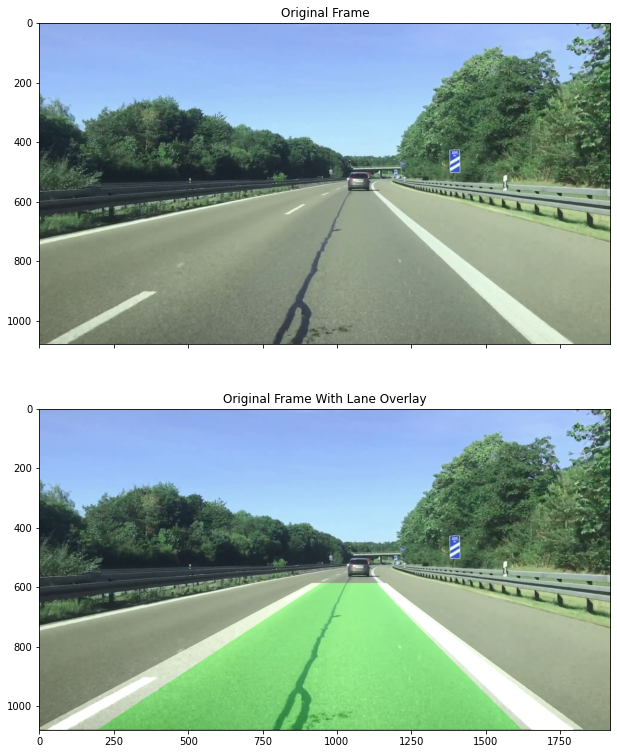

In [21]:
def dashcam_lane_lines_overlay_img(original_image, all_lane_points):
    (
        l_lane_l_xy_points,
        l_lane_r_xy_points,
        r_lane_l_xy_points,
        r_lane_r_xy_points,
    ) = all_lane_points

    # Generate an image to draw the lane lines on
    color_warped_canvas = np.zeros_like(original_image)

    # Draw a filled full lane onto the warped canvas
    full_lane_pts = np.vstack(
        [
            l_lane_r_xy_points,
            r_lane_l_xy_points,
        ]
    )
    cv2.fillPoly(color_warped_canvas, np.int_([full_lane_pts]), GREEN_COLOR)

    # Draw the left and right lanes onto the warped canvas
    left_lane_pts = np.vstack(
        [
            l_lane_l_xy_points,
            l_lane_r_xy_points,
        ]
    )
    right_lane_pts = np.vstack([r_lane_l_xy_points, r_lane_r_xy_points])
    cv2.fillPoly(color_warped_canvas, np.int_([left_lane_pts]), WHITE_COLOR)
    cv2.fillPoly(color_warped_canvas, np.int_([right_lane_pts]), WHITE_COLOR)

    # Warp the canvas back to original image space
    lane_overlay = color_warped_canvas
    lane_overlay = cv2.warpPerspective(
        color_warped_canvas,
        TO_DASHCAM_VIEW_MATRIX,
        (DASHCAM_WIDTH, DASHCAM_HEIGHT),
    )

    # Combine the result with the original image
    overlayed_dashcam_image = cv2.addWeighted(
        original_image, 1, lane_overlay, 0.3, 0
    )

    return overlayed_dashcam_image


dashcam_with_lane_overlay = dashcam_lane_lines_overlay_img(
    original_frame, (ll_xy_points, lr_xy_points, rl_xy_points, rr_xy_points)
)

# Plot

figure, (ax1, ax2) = plt.subplots(nrows=2, sharex=True)
figure.set_size_inches(13, 13)
ax1.set_title("Original Frame")
ax1.imshow(cv2.cvtColor(original_frame, cv2.COLOR_BGR2RGB))
ax2.set_title("Original Frame With Lane Overlay")
ax2.imshow(cv2.cvtColor(dashcam_with_lane_overlay, cv2.COLOR_BGR2RGB))

## Part 7 - Calculate Curvature and Car Position

We can treat the lanes as small arc lengths of large circles. The radii of these circles consitutes the radius of curvature of each lane, which will help us determine how the car should be steered at the current moment.

This can be visualized by the following picture [from Wikipedia](https://en.wikipedia.org/wiki/Radius_of_curvature#/media/File:Radius_of_curvature.svg):

![TODO](images/radius_of_curvature_illustration.png)

We want to have an outcome that makes sense in the real world. Since we manually set the perspective transform shape, and since the dashcam is constant, we know how many meters are accounted for in each pixel of the warped image. We manually set that here:

In [22]:
# Manually Tuned
METERS_PER_PIXEL_X = 3.7 / 255
METERS_PER_PIXEL_Y = 7.0 / 400

Next, [Wikipedia](https://en.wikipedia.org/wiki/Radius_of_curvature#Formula) also gives us the formula to find the radius of curvature given a polynomial $y(x)$ in Cartesian coordinates as follows:

$$R = \Biggr| \frac{\left(1 + y^{'}\right)^{\frac{3}{2}}}{y^{''}} \Biggr| \text{ , where } y^{'} = \frac{\partial y}{\partial x} \text{, } y^{''} = \frac{\partial y'}{\partial x}$$

We already found the scatter points previously. So, once again using the `numpy.polyfit` method and the Least Squared Errors techniques learned in Module 6 (because we want to be on the meters image scale), we can calculate this radius of curvature.

Since we want to evaluate the function derivates at a certain y-coordinate, we select the y-coordinate closest to the car, which is equal to `DASHCAM_HEIGHT`. This makes sense because the functions we have produce $x$ as an output, i.e. $x(y)$, and the equation above works the same.

In [23]:
POLYNOMIAL_VARIABLE = DASHCAM_HEIGHT * METERS_PER_PIXEL_Y

We implement everything in `calculate_curvature`.

In [24]:
def calculate_curvature(lane_x, lane_y):
    if len(lane_x) == 0:
        return -1
    # Points in real world distances
    best_params = np.polyfit(
        lane_y * METERS_PER_PIXEL_Y,
        lane_x * METERS_PER_PIXEL_X,
        2
    )
    first_deriv = 2 * best_params[0] * POLYNOMIAL_VARIABLE + best_params[1]
    second_deriv = 2 * best_params[0]
    
    if second_deriv == 0:
        return np.inf
    
    radius_of_curvature = (1 + first_deriv**2)**1.5 / np.absolute(second_deriv)

    return radius_of_curvature

left_lane_roc = calculate_curvature(l_x, l_y)
right_lane_roc = calculate_curvature(r_x, r_y)

# Confirm Output

print(f"Left lane ROC: {left_lane_roc:.2f}m, Right lane ROC: {right_lane_roc:.2f}m")

Left lane ROC: 416.13m, Right lane ROC: 260.16m


The results here make sense becuase the car is turning right. When it turns right, the left lane has less curve but the right lane has a steeper curve. A steeper right lane cuves means a smaller radius of curvature. The straighter left lane curve means a larger radius of curvature as the results show and as we expect. Of course, these numbers are as good as the lane detection algorithm is.

Next, having found the two radii of curvatures, we can calculate the car's center offset. That is, how far the center of the car is from the center between the two circumferences of these concentric circles fromed by the lanes.

As always, first we define any necessary constants. The only new constant we need is the car's location which is always at the center of the dashcam.

In [25]:
CAR_LOCATION = DASHCAM_WIDTH / 2

Now we calculate the center offset in `calculate_car_position`. A positive value means the car is to the _right_ of the center, while a negative value means it is to the _left_.

In [26]:
def calculate_car_position(left_lane_poly_params, right_lane_poly_params):
    # Fine the x coordinate of the lane line bottom
    Al, Bl, Cl = left_lane_poly_params
    Ar, Br, Cr = right_lane_poly_params
    bottom_left = Al * DASHCAM_HEIGHT ** 2 + Bl * DASHCAM_HEIGHT + Cl
    bottom_right = Ar * DASHCAM_HEIGHT ** 2 + Br * DASHCAM_HEIGHT + Cr

    true_lanes_center = (bottom_left + bottom_right) / 2
    center_offset = (CAR_LOCATION - true_lanes_center) * METERS_PER_PIXEL_X

    return center_offset


car_offset = calculate_car_position(l_curve_params, r_curve_params)

# Confirm Output

print(f"Car is {car_offset * 100:.2f}cm off center")

Car is 12.68cm off center


This slight value of ~13cm makes sense because the car seems to be to0 far to the right to be in the center of the lane. That is why the left lane extrapolation is almost cut off in the original image while the right lane has extra space from the edge of the image.

In [27]:
TEXT_X_POSITION = int((5/600)*DASHCAM_WIDTH)
CURVATURE_TEXT_POSITION = (TEXT_X_POSITION, int((20/338)*DASHCAM_HEIGHT))
CENTER_OFFSET_TEXT_POSITION = (TEXT_X_POSITION, int((40/338)*DASHCAM_HEIGHT))

Finally, we add the text in the `draw_curvature_and_offset` function below:

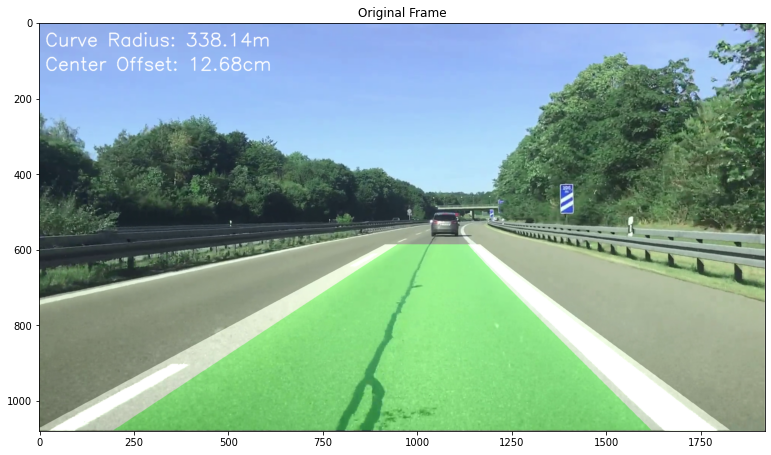

In [28]:
def draw_curvature_and_offset(
    image_with_overlay,
    left_radius_of_curvature,
    right_radius_of_curvature,
    center_offset,
):
    cv2.putText(
        image_with_overlay,
        f"Curve Radius: {((left_radius_of_curvature + right_radius_of_curvature) / 2):.2f}m",
        CURVATURE_TEXT_POSITION,
        cv2.FONT_HERSHEY_SIMPLEX,
        (float((0.5 / 600) * DASHCAM_WIDTH)),
        WHITE_COLOR,
        2,
        cv2.LINE_AA,
    )
    cv2.putText(
        image_with_overlay,
        f"Center Offset: {center_offset * 100:.2f}cm",
        CENTER_OFFSET_TEXT_POSITION,
        cv2.FONT_HERSHEY_SIMPLEX,
        (float((0.5 / 600) * DASHCAM_WIDTH)),
        WHITE_COLOR,
        2,
        cv2.LINE_AA,
    )

    return image_with_overlay


dashcam_overlay_and_text = draw_curvature_and_offset(
    dashcam_with_lane_overlay.copy(),
    left_lane_roc,
    right_lane_roc,
    car_offset,
)

# Plot

figure, ax = plt.subplots()
figure.set_size_inches(13, 13)
ax.set_title("Original Frame")
ax.imshow(cv2.cvtColor(dashcam_overlay_and_text, cv2.COLOR_BGR2RGB))

**REMARK**: Despite the formulas researched and used, empirical results show that this information can be highly inaccuracte. Espeically considering we just manually set the pixels per meters which is definitely _not_ the same for every camera. This part is just to show an additional interesting use of lane detection and shouldn't be scrutinized for accuracy too intensely. 

## Part 8 - Putting it all together for video

Having tuned all our constants, defined all our functions, extracted all our information, and dislayed everything on a sample image, it is time to put it all together in one convenient 2-stage pipeline!

During a live driving session, the only input we have is the current image of the dashcam. Even so we split up our pipeline into two pipelines because we will store the intermediate lane polynomial parameters to calculate a **moving average** over the last 30 frames of the polynomial parameters.

This makes sense because while the image changes quickly and may introduce temporary new noise, the lanes should not change _too much_ so the average should help improve resistance to drastic lane changes which are unlikely.

First, we have `get_lanes_poly_params` (Parts 2-5a) to get the lane polynomial parameters and `get_lanes_detected_img` (Parts 5b-7) to use the parameters to create an overlayed image.

These function do not do anything new. As one pipeline, they take an original image and draw the lane boundaries on it like we discussed above.

The steps we discussed are labeled with comments and the functions **have no state** so images can consistently be put through this pipeline in a quick manner to generate a new video stream showing where the lanes are at all times. One **efficiency** improvement of my solution as opposed to the tutorial solution is that I take advantage of these constants to not have to do calculations repeatedly (such as the transformation matrix calculations) because these values are constant for every image.

As a test, we run the sample image we used through the 2-stage pipeline as so:

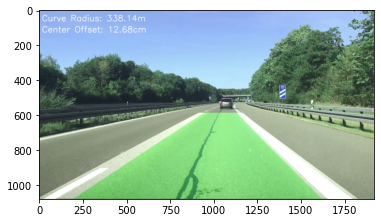

In [29]:
def get_lanes_poly_params(input_frame):
    # Part 2
    lane_lines_and_edges = find_lane_lines_and_edges(input_frame)

    # Part 3
    warped_mask = get_lanes_perspective_view(
        lane_lines_and_edges, TO_AERIAL_VIEW_MATRIX
    )

    # Part 4
    lanes_histogram = get_histogram(warped_mask)

    # Part 5a
    (
        (l_x, l_y, r_x, r_y),
        windowed_mask,
    ) = get_lane_line_indices_sliding_windows(warped_mask, lanes_histogram)
    left_lane_curve_params = get_lane_curve_params(l_x, l_y)
    right_lane_curve_params = get_lane_curve_params(r_x, r_y)

    return left_lane_curve_params, right_lane_curve_params


def get_lanes_detected_img(input_frame, l_curve_params, r_curve_params):
    # Part 5b
    left_fitx = (
        l_curve_params[0] * Y_RANGE ** 2
        + l_curve_params[1] * Y_RANGE
        + l_curve_params[2]
    )
    right_fitx = (
        r_curve_params[0] * Y_RANGE ** 2
        + r_curve_params[1] * Y_RANGE
        + r_curve_params[2]
    )

    (ll_xy_points, lr_xy_points, rl_xy_points, rr_xy_points) = get_lane_points(
        left_fitx[..., np.newaxis],
        right_fitx[..., np.newaxis],
        Y_RANGE[..., np.newaxis],
    )

    # Part 6
    dashcam_with_lane_overlay = dashcam_lane_lines_overlay_img(
        input_frame, (ll_xy_points, lr_xy_points, rl_xy_points, rr_xy_points)
    )

    # Part 7
    left_lane_roc = calculate_curvature(left_fitx, Y_RANGE)
    right_lane_roc = calculate_curvature(right_fitx, Y_RANGE)
    car_offset = calculate_car_position(l_curve_params, r_curve_params)
    dashcam_overlay_and_text = draw_curvature_and_offset(
        dashcam_with_lane_overlay.copy(),
        left_lane_roc,
        right_lane_roc,
        car_offset,
    )

    return dashcam_overlay_and_text


l_lane_params, r_lane_params = get_lanes_poly_params(original_frame)
lanes_overlayed_img = get_lanes_detected_img(
    original_frame, l_lane_params, r_lane_params
)

plt.imshow(cv2.cvtColor(lanes_overlayed_img, cv2.COLOR_BGR2RGB))


The image produced above is the same we got after running all the functions step by step.

Now, we are ready to try a video. We try the same video the sample image came from first:

In [30]:
# Manually Tuned values
if TEST_IMAGE_NAME.startswith("images/samples/sunny"):
    CLIP_DURATION = 13
    TEST_VIDEO_NAME = "videos/samples/sunny"
elif TEST_IMAGE_NAME.startswith("images/samples/nighttime"):
    CLIP_DURATION = 11
    TEST_VIDEO_NAME = "videos/samples/nighttime"
elif TEST_IMAGE_NAME.startswith("images/samples/raining"):
    CLIP_DURATION = 10
    TEST_VIDEO_NAME = "videos/samples/raining"
elif TEST_IMAGE_NAME.startswith("images/samples/lane_change"):
    CLIP_DURATION = 9
    TEST_VIDEO_NAME = "videos/samples/lane_change"
else:
    raise (Exception("Add your own Region points for this custom video!"))

NUM_FRAMES_EXPECTED = CLIP_DURATION * 60

You can watch this sample video right here in the notebook:

In [31]:
display.Video(f"{TEST_VIDEO_NAME}.mp4", width=800, height=450)

In the following cell, the `make_lane_overlay_video` function takes in a video name as opposed to an image name like `get_lanes_detected_img` above. It uses OpenCV's video writing methods to read in the video at its file location and write it out the resulting video with lanes overalayed at a separate file location.

It finally returns the location of the new video.

In [32]:
def make_lane_overlay_video(original_video_name):
    original_video_path = original_video_name.split('/')
    lane_overlay_video_name = f"{'/'.join(original_video_path[:-2])}/{original_video_path[-1]}_lanes.mp4"
    # Load a video
    cap = cv2.VideoCapture(f"{original_video_name}.mp4")

    # Create a VideoWriter object so we can save the video output
    ENCODING_ALGO = "vp90"  # SLOW. But necessary to play in Chrome Notebook
    ENCODING_ALGO = "mp4v"  # FAST. But cannot play in Chrome Notebook.
    fourcc = cv2.VideoWriter_fourcc(*ENCODING_ALGO)
    result = cv2.VideoWriter(
        lane_overlay_video_name,
        fourcc,
        60.0,  # Frames per second
        (DASHCAM_WIDTH, DASHCAM_HEIGHT),
    )

    img_count = 1

    prev_left_fit = [LANE_PARAMS_ZEROS]
    prev_right_fit = [LANE_PARAMS_ZEROS]

    start_time = time.time()

    # Process the video
    while cap.isOpened():
        print(f"Processing Img #{img_count} out of {NUM_FRAMES_EXPECTED} (expected)", end="\r")
        img_count += 1

        # Capture one frame at a time
        success, original_frame = cap.read()

        # Do we have a video frame? If true, proceed.
        if success:

            # Get the lane overlay image
            l_lane_params, r_lane_params = get_lanes_poly_params(original_frame)

            # Make sure we have nonzero pixels
            if (l_lane_params == 0).all():
                prev_left_fit.append(prev_left_fit[-1])
            else:
                prev_left_fit.append(l_lane_params)

            if (r_lane_params == 0).all():
                prev_right_fit.append(prev_right_fit[-1])
            else:
                prev_right_fit.append(r_lane_params)

            # Calculate the moving average
            if len(prev_left_fit) > 30:
                prev_left_fit.pop(0)
                prev_right_fit.pop(0)
                l_lane_params = sum(prev_left_fit) / len(prev_left_fit)
                r_lane_params = sum(prev_right_fit) / len(prev_right_fit)

            lanes_overlayed_img = get_lanes_detected_img(
                original_frame, l_lane_params, r_lane_params
            )

            # Write the frame to the output video file
            result.write(lanes_overlayed_img)

            # Uncomment this to see the pictures generate 1 by 1
            # in the notebook
#             try:
#                 plt.imshow(cv2.cvtColor(lanes_overlayed_img, cv2.COLOR_BGR2RGB))
#                 display.display(plt.gcf())
#                 display.clear_output(wait=True)
#                 time.sleep(2)
#             except KeyboardInterrupt:
#                 break

        # No more video frames left
        else:
            break

    end_time = time.time()
    
    # Stop when the video is finished
    cap.release()

    # Release the video recording
    result.release()

    cv2.destroyAllWindows()

    print(
        "Done processing "
        f"{img_count}"
        " images in "
        f"{end_time - start_time:.2f}"
        "s. Saved video as "
        f"{lane_overlay_video_name}"
    )

    return lane_overlay_video_name


lanes_overlayed_filename = make_lane_overlay_video(TEST_VIDEO_NAME)

Done processing 780 images in 142.65s. Saved video as videos/sunny_lanes.mp4


If you use the default `mp4v` encoding you'll have to play the videos with a video player on your computer. Otherwise, if you use the `vp90` encoding you can play them directly in this notebook but the encoding is much slower.

In a real-time situation we would use fast encoding to display this to a user screen but making a car control decision does not require this kind of visualization.

## Part 9 - Conclusions

For visualization, I encoded the lanes overlay video of this current test input in a notebook-friendly format so you can visualize the final results in the notebook here. This is the best result I obtain when I modified the `LUMINOSITY_THRESHOLD`, `RED_THRESHOLD`, and `SATURATION_THRESHOLD` parameters to overfit on that video.

In [33]:
display.Video(
    f"videos/expected/{TEST_VIDEO_NAME.split('/')[-1]}_expected.mp4",
    width=800,
    height=450,
)

The lane detection does an excellent job most of the time, but sometimes the extra lanes can fool it which causes it to flicker. A result like this required several hours spent tunning the parameters to fit for the camera being used.

Feel free to generate lane overlays videos with the different inputs included in this project! It is as simple as changing the `TEST_IMAGE_NAME` at the start of the project to one of the commented out values. They correspond to the following videos:
* `videos/samples/sunny`
* `videos/samples/lane_change`
* `videos/raining`
* `videos/nighttime` - This video I recorded myself in my car!

As we mentioned, the hardest part was getting the parameters to fit to the camera. I did my best to calibrate the parameters as explained in the sample images of Part 2, but finding a one-size-fits-all is difficult for the different weather-lighting conditions and especially because **different cameras and cars produces images with different quality**. Different lighting and different camera quality factor into the parameters needed. Cars also have different lighting available from their headlights. Videos like my `nighttime` video had much lower resolution, not to mention that I had to change the video dimensions of it with an online tool.

Generalizing requires considering challenging scenarios with rain, lane changes, oncoming traffic, or even the hood of the car (especially if it is white) itself which can get in the way.

However, using customized parameters, I _was_ able to produce results that were better than the original tutorial video. For the sunny video I fixed one awkward jump to a far lane in its results.

For the other inputs I got passable results even though they were still really hurt my the weather conditions. However, the comparison with the tutorial code is not far because the tutorial code did not change parameters for these different inputs.

You can view the tutorial's output video here (remark they render at 20 frames per second):

In [34]:
if TEST_IMAGE_NAME.startswith("images/samples/lane_change"):
    raise(Exception("The original tutorial video failed to generate a video for this one!"))
display.Video(
    f"videos/tutorial/{TEST_VIDEO_NAME.split('/')[-1]}_tutorial.mp4",
    width=800,
    height=450,
)

The steps I took to improve results included:
1. A good luminosity threshold value
1. A good edge jump magnitude threshold
1. A good red channel threshold value
1. A good saturation threshold value
1. A good method for combining image components to get a mask
1. A good region of interest on the mask (we already customized it but it might need further experimentation)
1. A good threshold value for how far in front of the car we should look for points
1. A good segmentation algorithm either with sliding windows or with something we discussed in class
1. A good moving average value to resist large changes in curvature
1. A good padding value for the transformation matrix

You can see the videos I generated in `videos/expected/` to see the results of the different videos and generate your own results by running the notebook with different `TEST_IMAGE_NAME` values. You can especially experiment with different region of interests values and parameters as already discussed.

This project drew on the knowledge learned in several modules of CS 484/684.

Some of the modules we saw include the following:
* Image Processing for Edge Detection and Kernel Smoothing to detect lanes (Module 3)
* Perspective Transform (Modules 4 & 5)
* Estimating Polynomial Fit for lane lines (Module 6)
* A new way to segment the lane pixels from the mask (Module 9)
* Overfitting the HLS parameters to 1 video vs Generalizing (Module 10)

The problem could also highly benefit from the other modules that were not yet included:
* Construct a 3D view of the world to plan car escape routes (Module 7)
* Dense Stereo to determine distance of other cars and signs (Module 8)
* CNNs to classify road signs after supervised training (Module 10)
* CNNs to segment road signs from world view picture (Module 11)
* CNNs to do Monocular Depth Estimation (Module 12)

This project taught me a lot about how consistent representation of data is important especially as data is passed to other functions in a pipeline. If I could do it again I would generate all data using my own dashcam and tailored to that.

Additionally, the organized setup of functions working with other functions was essential for debugging and improving the final video results.

Given more time it will be very exciting to try and implement additional features to detect the objects around the car and help it make decisions about the car's operation such as steering, braking, and accelerating.